<a href="https://colab.research.google.com/github/sanjibani/RAG-learnings/blob/main/langchain_Rag_tut1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests

In [3]:
import os
import getpass

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [8]:
if not os.environ.get("ANTHROPIC_API_KEY"):
  os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("enter")

enter··········


In [ ]:
%pip install -U langchain-anthropic

In [35]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("claude-3-5-sonnet-20240620" , model_provider="anthropic")

In [ ]:
%pip install -U langchain-openai

In [15]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [16]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [17]:
# loading document and indexing
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [18]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [20]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['adbe41cc-5ec7-47da-a177-b57fb3f3371c', 'caf9e9c9-15ab-4d88-97c2-a42020e99c6e', 'de8aeaa3-739c-4e6d-86a5-f90c2e9bdee2']


In [21]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [22]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question:str
    context:List[Document]
    answer: str

In [23]:
def retrieve(state:State):
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs }




In [24]:
def generate(state:State):
  docs_content = "\n\n".join(docs.page_content for doc in state["context"])
  messages = prompt.invoke({"question": state["question"] , "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}

In [26]:
from langgraph.graph import START , StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve , generate])
graph_builder.add_edge(START , "retrieve")
graph = graph_builder.compile()

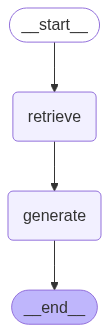

In [27]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='f1a0d241-6813-4544-a7ed-1921f43b7155', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

In [37]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [47]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    print(Search)
    structured_llm = llm.with_structured_output(Search)
    print(state["question"])
    query = structured_llm.invoke(state["question"])
    print(query)
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

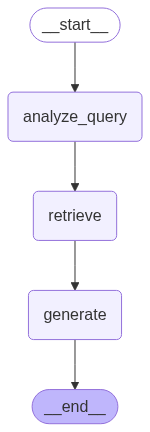

In [45]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

<class '__main__.Search'>
What does the end of the post say about Task Decomposition?
{'query': 'Task Decomposition', 'section': 'end'}
{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='b69f416c-29cc-42c2-86a5-8698f920da7c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictl